# Parameter Tuning

    Find best fill nan strategy: 
    mean, median, drop, last value seen or 0

In [2]:
!pip install pandas
!pip install sklearn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# empty list to append metric values
mae_gen = []
mae_nor = []
mae_spi = []
rmse_gen = []
rmse_nor = []
rmse_spi = []

# Data set processing and tuning:

In [3]:
# fill nan function
def fill_nan(method_):
    data.fillna(method_, inplace = True)
    return data

# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

fillnan_range = [data.mean(), 
                 data.median(),
                 0
                 ]

fillnan_label = ['Mean', 'Median', 'Last available', 'Zero', 'Drop']
means = []
std = []

for i in fillnan_range:
    
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    
    # set predictive window 
    data = data.loc[data.index > 2018070000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    
    # fill nan values
    data = fill_nan(i)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']

    X = X.astype('float64')
    X = X.round(5)

    # divide data into train and test with 15% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.15, shuffle=False)

    # feature scaling
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    # create regressor 
    regressor = SVR()
    regressor.fit(X_train, y_train)

    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

# drop nan method

# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    
# set predictive window
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# drop nan
data.dropna(inplace = True)

X = data.iloc[:, 0:15]
y = data.loc[:, 'Offers']

X = X.astype('float64')
X = X.round(5)

# divide data into train and test with 15% test data
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.15, shuffle=False)

# feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# create regressor 
regressor = SVR()
regressor.fit(X_train, y_train)

# predict for X_test  
y_pred = regressor.predict(X_test)

rmse_error = mse(y_test, y_pred, squared = False)
mae_error = mae(y_test, y_pred)

rmse_gen.append(rmse_error)
mae_gen.append(mae_error)

# =============================================================================
# Metrics evaluation on spike regions
# =============================================================================

y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])

# create array same size as y_test
y_spike_occ = y_spike_occ.iloc[- len(y_test):]
y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values

# smal adjustment
y_test.replace(0, 0.0001,inplace = True)

# select y_pred and y_test only for regions with spikes
y_test_spike = (y_test.T * y_spike_occ).T
y_pred_spike = (y_pred.T * y_spike_occ).T
y_test_spike = y_test_spike[y_test_spike != 0]
y_pred_spike = y_pred_spike[y_pred_spike != 0]

# calculate metric
rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
mae_spike = mae(y_test_spike, y_pred_spike)

rmse_spi.append(rmse_spike)
mae_spi.append(mae_spike)

# =============================================================================
# Metric evaluation on normal regions
# =============================================================================

# inverse y_spike_occ so the only normal occurences are chosen
y_normal_occ = (y_spike_occ - 1) * (-1)

# sanity check
y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

# select y_pred and y_test only for normal regions
y_test_normal = (y_test.T * y_normal_occ).T
y_pred_normal = (y_pred.T * y_normal_occ).T
y_test_normal = y_test_normal[y_test_normal != 0.00]
y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

# calculate metric
rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
mae_normal = mae(y_test_normal, y_pred_normal)

rmse_nor.append(rmse_normal)
mae_nor.append(mae_normal)


# ffill method

# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    
# set predictive window
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan with last available value
data.fillna(method = 'ffill', inplace = True)

X = data.iloc[:, 0:15]
y = data.loc[:, 'Offers']

X = X.astype('float64')
X = X.round(5)

# divide data into train and test with 15% test data
X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.15, shuffle=False)

# feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# create regressor 
regressor = SVR()
regressor.fit(X_train, y_train)

# predict for X_test  
y_pred = regressor.predict(X_test)

rmse_error = mse(y_test, y_pred, squared = False)
mae_error = mae(y_test, y_pred)

rmse_gen.append(rmse_error)
mae_gen.append(mae_error)

# =============================================================================
# Metrics evaluation on spike regions
# =============================================================================

y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])

# create array same size as y_test
y_spike_occ = y_spike_occ.iloc[- len(y_test):]
y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values

# smal adjustment
y_test.replace(0, 0.0001,inplace = True)

# select y_pred and y_test only for regions with spikes
y_test_spike = (y_test.T * y_spike_occ).T
y_pred_spike = (y_pred.T * y_spike_occ).T
y_test_spike = y_test_spike[y_test_spike != 0]
y_pred_spike = y_pred_spike[y_pred_spike != 0]

# calculate metric
rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
mae_spike = mae(y_test_spike, y_pred_spike)

rmse_spi.append(rmse_spike)
mae_spi.append(mae_spike)

# =============================================================================
# Metric evaluation on normal regions
# =============================================================================

# inverse y_spike_occ so the only normal occurences are chosen
y_normal_occ = (y_spike_occ - 1) * (-1)

# sanity check
y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 

# select y_pred and y_test only for normal regions
y_test_normal = (y_test.T * y_normal_occ).T
y_pred_normal = (y_pred.T * y_normal_occ).T
y_test_normal = y_test_normal[y_test_normal != 0.00]
y_pred_normal = y_pred_normal[y_pred_normal != 0.00]

# calculate metric
rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
mae_normal = mae(y_test_normal, y_pred_normal)

rmse_nor.append(rmse_normal)
mae_nor.append(mae_normal)

# Results:

In [4]:
    
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = fillnan_label)

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
Mean,32.412550,17.227713,82.901593,68.789144,13.084098,9.439789
Median,32.377650,17.144500,82.906989,68.792520,12.979049,9.343497
Last available,33.653365,17.823902,83.135362,68.914278,16.114842,10.107125
Zero,32.603240,17.241069,32.693663,15.196512,32.590198,17.535485
Drop,32.538605,17.220975,83.035588,68.859606,13.313874,9.421391


# Highlight best results:

In [5]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
Mean,32.412550,17.227713,82.901593,68.789144,13.084098,9.439789
Median,32.377650,17.144500,82.906989,68.792520,12.979049,9.343497
Last available,33.653365,17.823902,83.135362,68.914278,16.114842,10.107125
Zero,32.603240,17.241069,32.693663,15.196512,32.590198,17.535485
Drop,32.538605,17.220975,83.035588,68.859606,13.313874,9.421391


In [6]:
!pip install matplotlib

# Plot results:

<IPython.core.display.Javascript object>


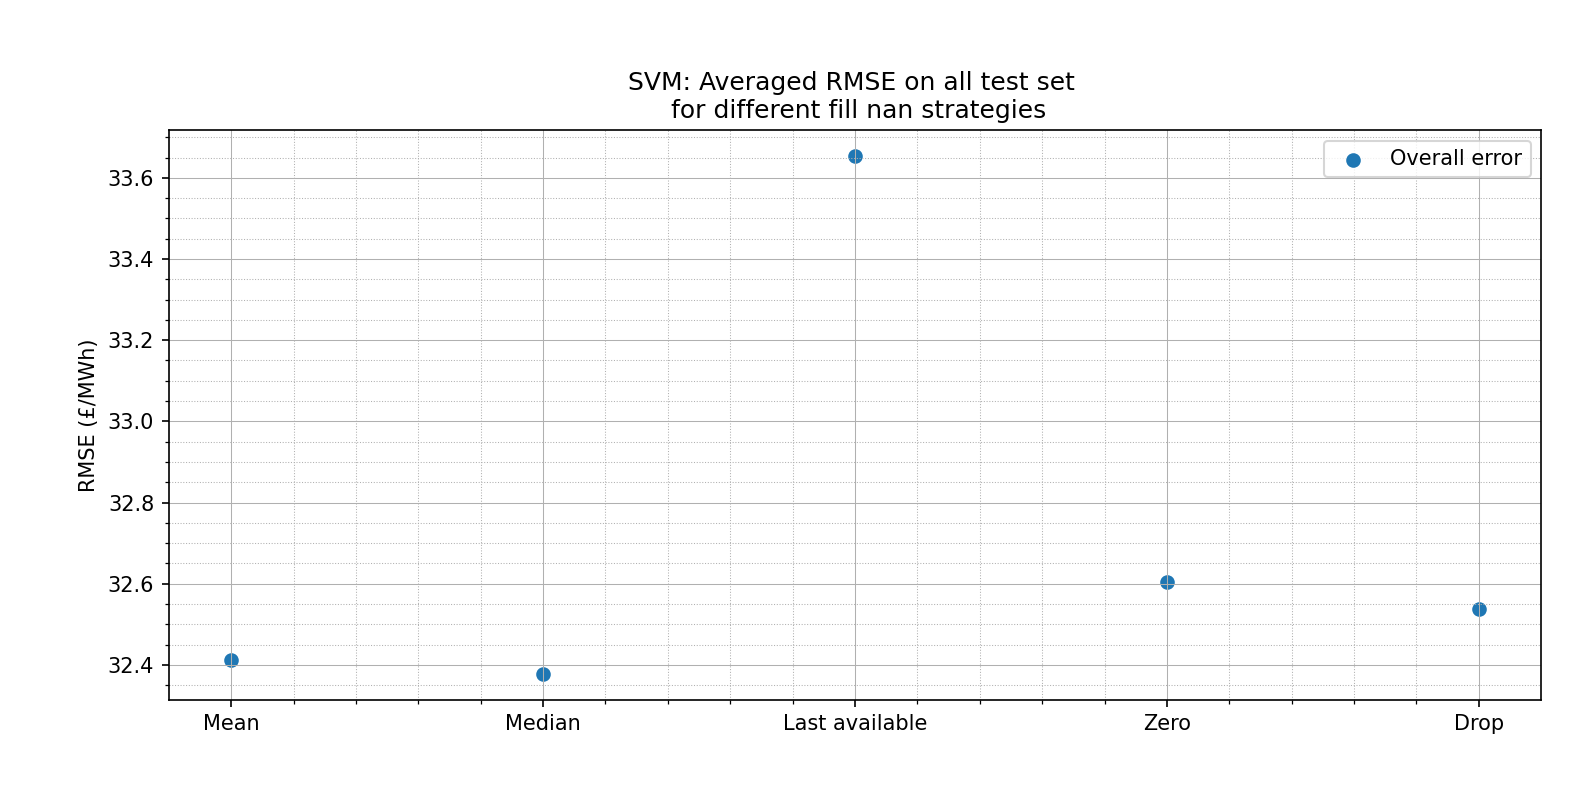

<IPython.core.display.Javascript object>


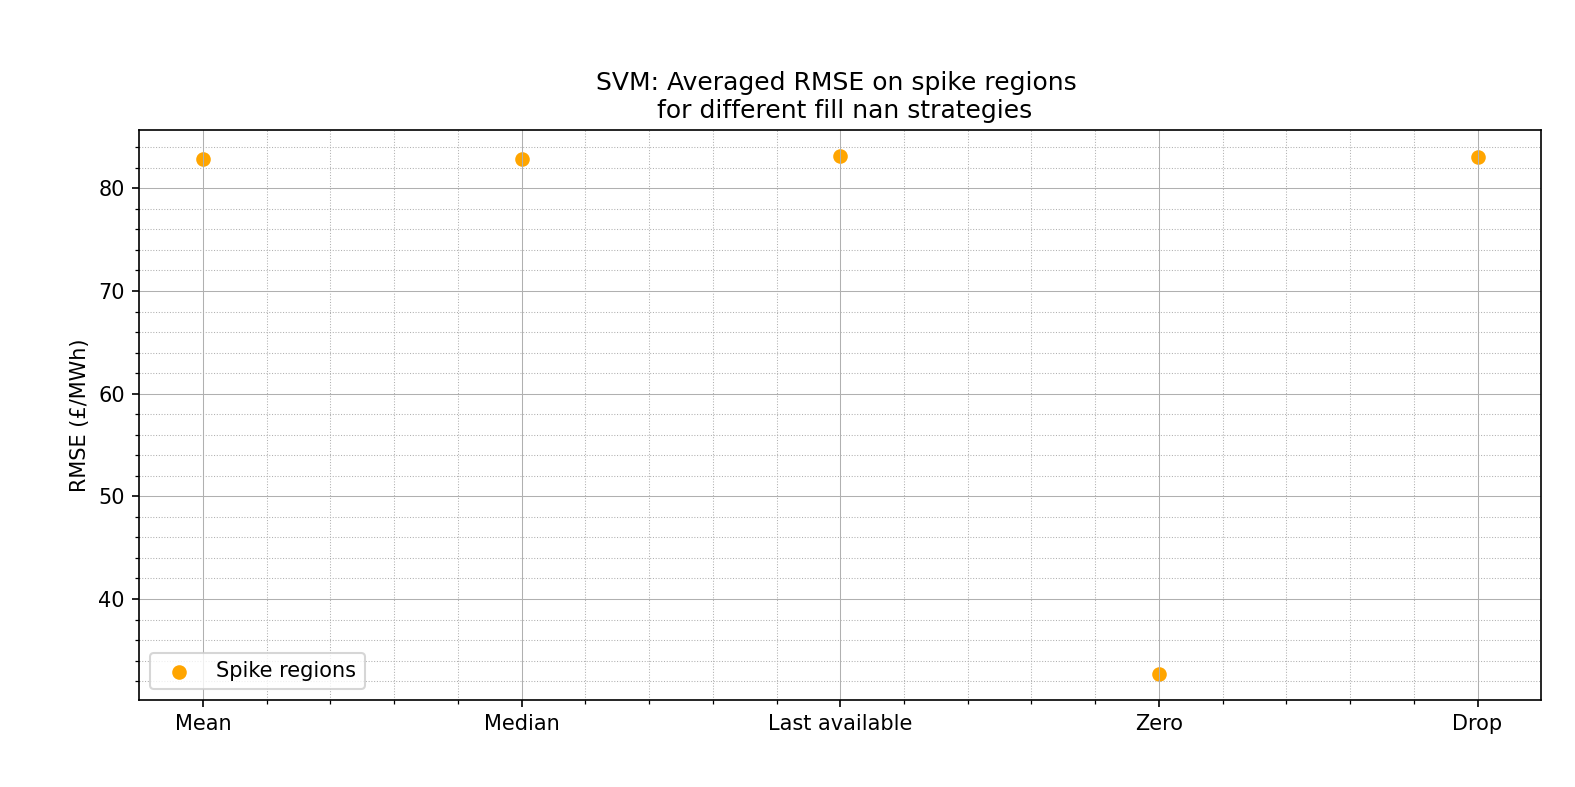

<IPython.core.display.Javascript object>


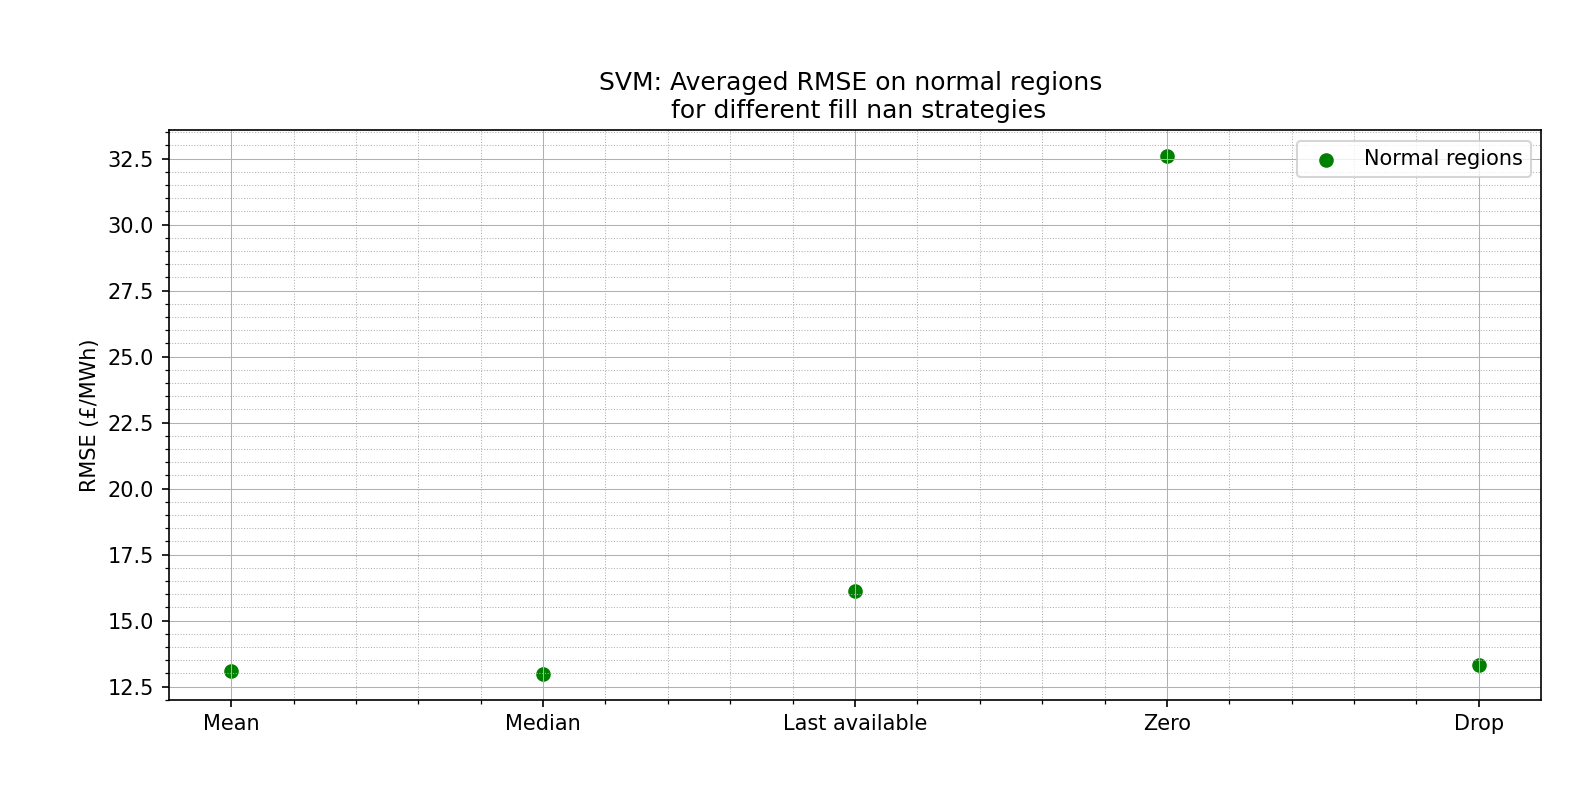

In [7]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE on all test set \n for different fill nan strategies')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_gen, label = 'Overall error')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), fillnan_label)
plt.tight_layout()
plt.savefig('RMSE_best_fill_nan_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE on spike regions \n for different fill nan strategies')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), fillnan_label)
plt.tight_layout()
plt.savefig('RMSE_best_fill_nan_spike.png')


plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged RMSE on normal regions \n for different fill nan strategies')
plt.scatter(x = list(range(len(rmse_gen))), y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), fillnan_label)
plt.tight_layout()
plt.savefig('RMSE_best_fill_nan_normal.png')

<IPython.core.display.Javascript object>


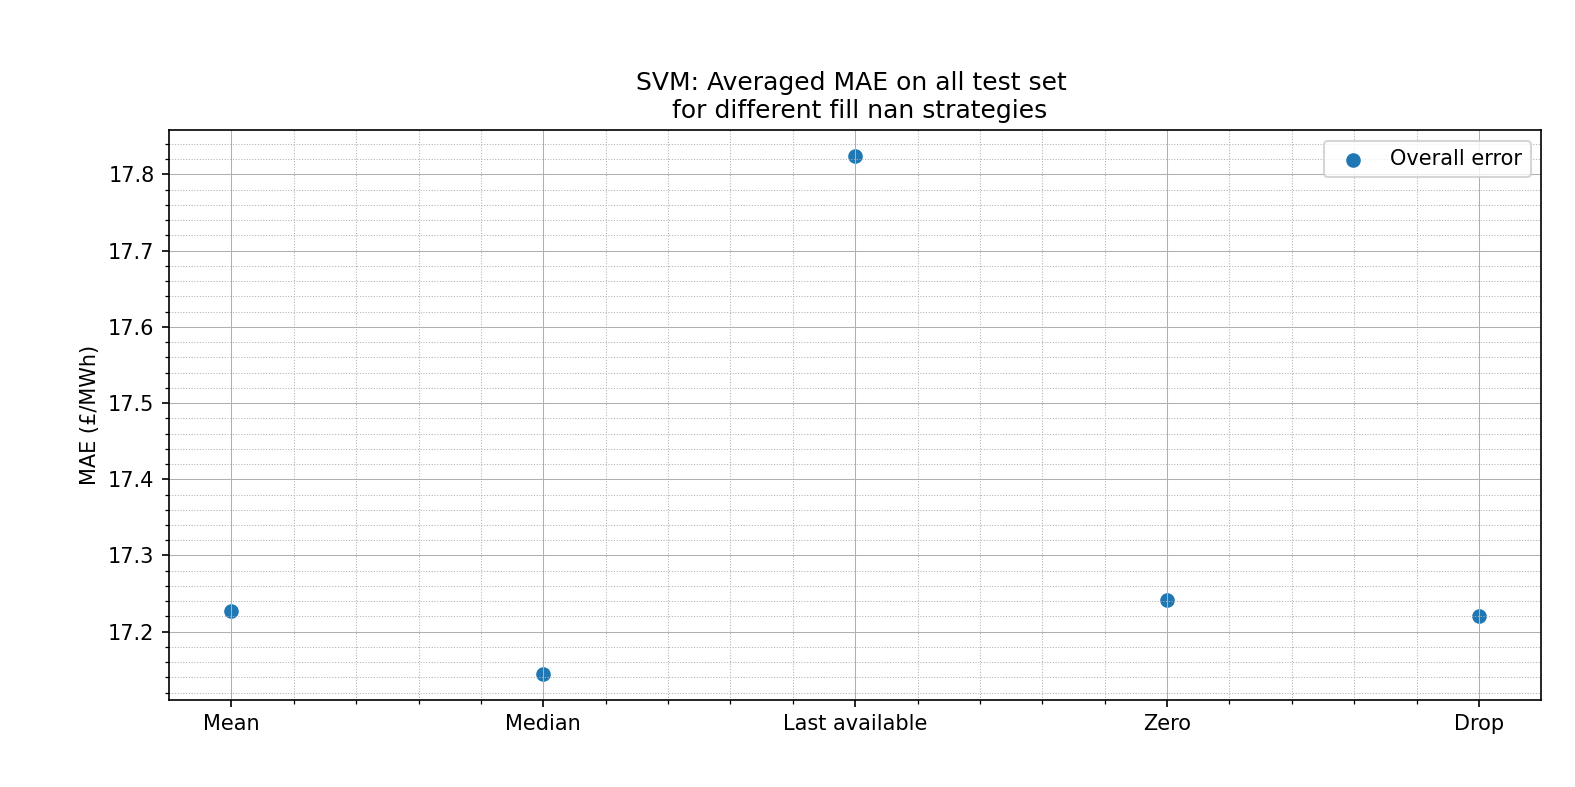

<IPython.core.display.Javascript object>


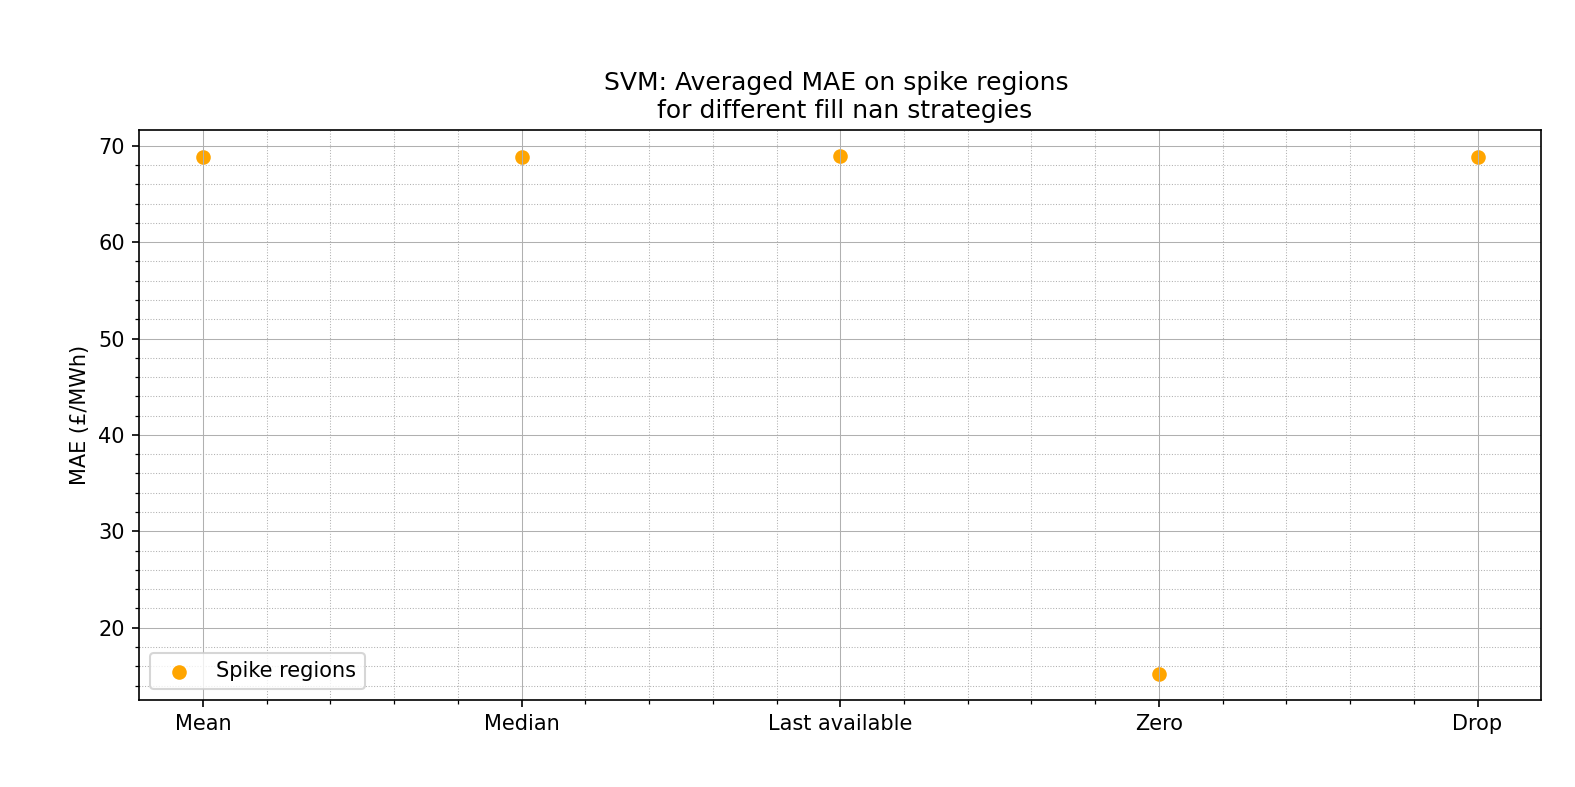

<IPython.core.display.Javascript object>


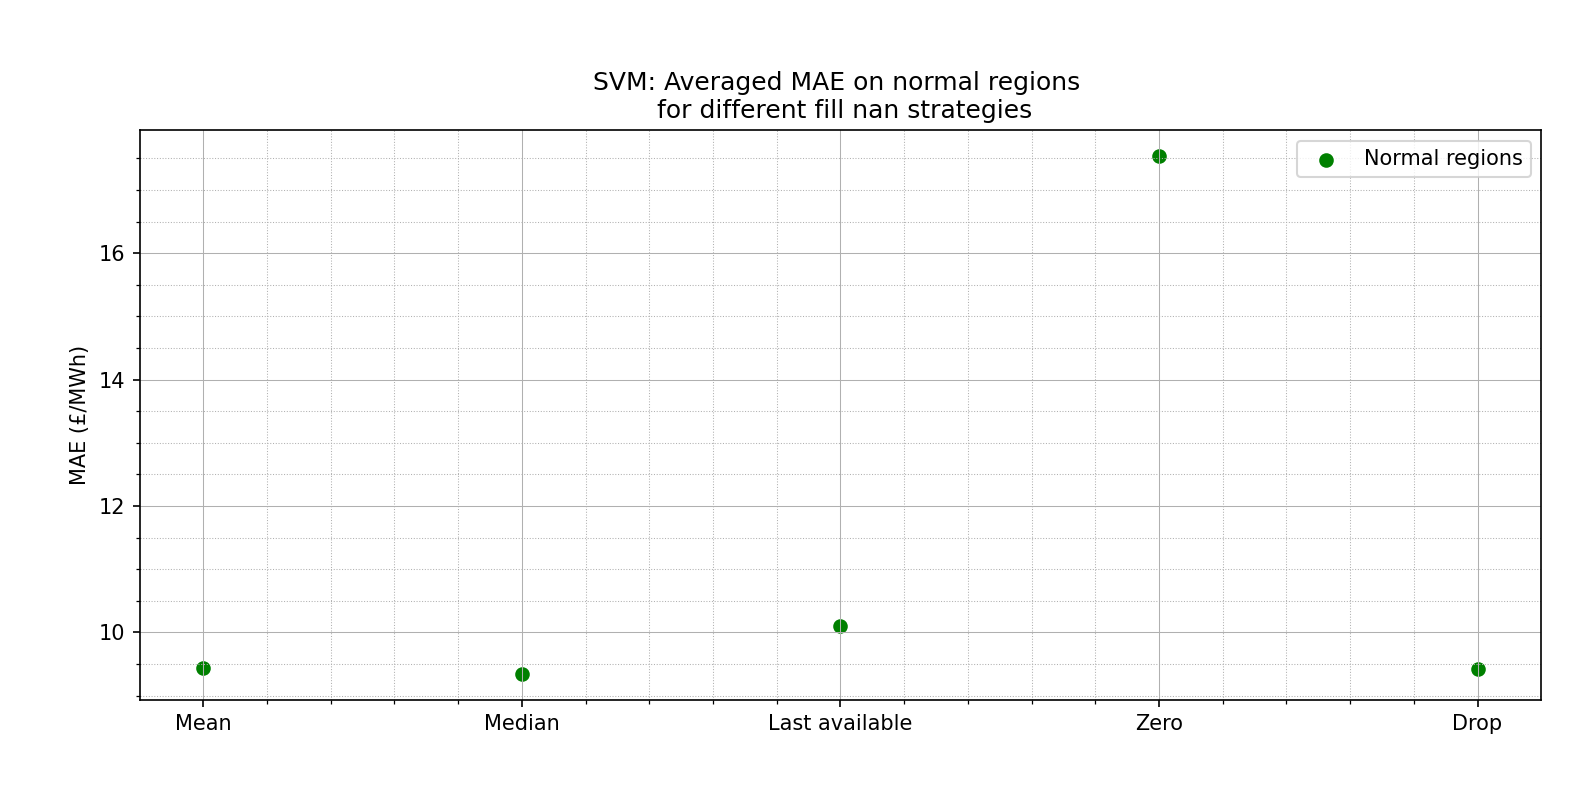

In [8]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE on all test set \n for different fill nan strategies')
plt.scatter(x = list(range(len(rmse_gen))), y = mae_gen, label = 'Overall error')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), fillnan_label)
plt.tight_layout()
plt.savefig('MAE_best_fill_nan_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE on spike regions \n for different fill nan strategies')
plt.scatter(x = list(range(len(rmse_gen))), y = mae_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), fillnan_label)
plt.tight_layout()
plt.savefig('MAE_best_fill_nan_spike.png')


plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVM: Averaged MAE on normal regions \n for different fill nan strategies')
plt.scatter(x = list(range(len(mae_gen))), y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xticks(list(range(len(rmse_gen))), fillnan_label)
plt.tight_layout()
plt.savefig('MAE_best_fill_nan_normal.png')